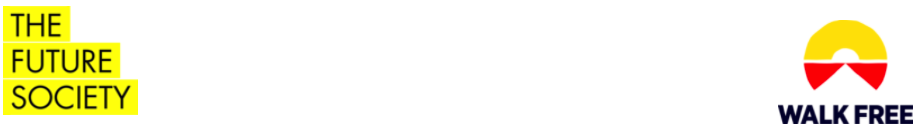

#*Project AIMS (AI against Modern Slavery)*
---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1Tc8H5U8xWnAsayKtxKS4CKC7BZbPcrQb/view?usp=sharing).


##  Impact on Company's Behaviour 
 
## Does the company’s statement describe a change in their policy that occurred as a direct result of the UK Modern Slavery Act 2015?
 
The UK Modern Slavery Act (MSA) 2015 was one of the first legislation of its kind in the world. The result of the introduction of the MSA is that all commercial organisations with an annual turnover of over £36 million in the UK must publish a slavery and human trafficking statement. However, the extent to which the introduction of the MSA has shaped the modern slavery policies of companies is currently unknown. Knowing whether or not a company has shaped its modern slavery policy in response to the MSA helps us better understand the MSA’s impact on company behaviour.
 
The goal of this activity is to identify whether a company’s statement describes a change in their policy that occurred as a direct result of the UK Modern Slavery Act 2015. Some companies specifically pointed out in their statement that their behaviour has changed as a result of it.
 
Examples of this type of change include updating the company’s code of conduct and/or supplier code, developing a new modern slavery company policy, changing their risk assessment strategy, updating their supplier contracts, developing (or adapting) their training program, and developing new key performance indicators.
 
 
For more details, please refer to [WikiRate’s research on MSA Impact on Company Behaviour.](https://wikirate.org/Walk_Free_Foundation+MSA_Impact_on_Company_Behaviour)
 
## Labelled Dataset
In each case, for the label to be 'Yes', the company must say that a change has occurred as a direct result of the UK Modern Slavery Act 2015. If the company identifies one or more changes that have occurred as a direct result of the MSA, the annotators labelled the statement with 'Yes', and details were provided in the Comments. In this case, there is no information given about whether the MSA has shaped the company’s policy; the label selected was  'No'.
 



In [ ]:
#!pip install snorkel
#!pip install unidecode
#!pip install contractions
#!pip install TextBlob
#!python -m spacy download en_core_web_sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


## Setup

In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import spacy
import string
import snorkel
import nltk
from nltk.corpus import wordnet
import sys
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.preprocess import preprocessor
from textblob import TextBlob
import re
from utils import sentencizer, evaluation_rb
from utils.preprocessing import *

### 🗄️ You can access the data used in this notebook [here](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).



In [ ]:
metric = 'Walk Free Foundation+MSA Impact on Company Behaviour'

labeled_dataset = load_dataset(metric, "labeled-dataset.csv")
data = labeled_dataset[labeled_dataset[metric] != "Unknown" ]

Number of available statements for Walk Free Foundation+MSA Impact on Company Behaviour -> 935



In [ ]:
print('Final number of data points in the labeled dataset is:')
print(data[metric].value_counts())

Final number of data points in the labeled dataset is:
No     599
Yes    278
Name: Walk Free Foundation+MSA Impact on Company Behaviour, dtype: int64


### Preprocessing
Some basic steps to pre-process statements are performed which include:
- lemmatisation
- remove company names
- fix contractions (contraction is a shortened version of the spoken and written forms of a word)
- remove empty lines
- remove accents
- remove punctuation
- normalize text

In [ ]:
preprocessing = Preprocessing()
data['clean_text'] = data.TEXT.apply(lambda row: preprocessing(row))

Preprocessing...


In [ ]:
def print_side_by_side(str1, str2, size=30, space=4):
    while str1 or str2:
        print(str1[:size].ljust(size) + " " * space + str2[:size])
        str1 = str1[size:]
        str2 = str2[size:]


print_side_by_side(data.TEXT[0][:500], data.clean_text[0][:500])

Slavery and human trafficking     slavery and human trafficking 
statement 2018
1. Introduction    statement 2018 1 . introductio
 2. About our business 3. Our     n 2 . about business 3 . code 
code and human rights policy 4    and human right policy 4 . mod
. Modern slavery and our gover    ern slavery and governance 5 .
nance 5. Training 6. Assessing     train 6 . assess the risk of 
 the risk of modern slavery 7.    modern slavery 7 . manage mode
 Managing modern slavery risks    rn slavery risk 8 . work with 
 8. Working with others 9. Loo    other 9 . look ahead c 2019 sl
king ahead
© BP 2019

Slavery    avery and human trafficking st
 and human trafficking stateme    atement 2018 this statement re
nt 2018

This statement relate    late to the financial year end
s to the financial year ending     31 december 2018 . be publish
 31 December 2018. It is publi     by p.l.c . and relevant subsi
shed by BP p.l.c. and its rele    diaries1 in compliance with th
vant subsidiaries1 in com

### Synonyms
For the labeling purpose, the synonyms of ‘slavery’, ‘approval’ and ‘statement’. and contrasting connectors are taken into consideration. For example, ‘slavery’ can be written as 'enslavement', 'servitude', 'subjugation', 'trafficking', 'forced labor', ‘forced labor’, ‘child labor’, ‘child labor’ and ‘training’ can be written as 'coaching', 'guidance', 'instruction', 'training', 'trained', 'educating'.

In [ ]:
synonyms_act = ['Modern Slavery Act','MSA', 'modern slavery']
synonyms_verbs = ['lead to', 'cause', 'produce', 'account', 'trigger', 'induce', 'influence', 'contribute',\
'result', 'arise', 'stem', 'attribute', 'acribe','initiate', 'improve','begin','start']

synonyms_nouns = ['reason', 'cause', 'consequence', 'influence', 'impact', 'step', 'progress','steps']
connectors = ['consequently','as a result','therefore','as a consequence','for this reason','thus','since','because',\
'due to','so that', 'accordingly', 'owing to', 'hence', 'that is why', 'in order to', 'in order that','thereby',\
'on account of', 'in response to']
before = ['before', 'prior to', 'preliminary to', 'earlier than', 'in advance of', 'in ahead of']



dic_all_terms = {'act':synonyms_act,
                 'verbs': synonyms_verbs,
                 'nouns': synonyms_nouns,
                 'connectors': connectors,
                 'before': before}

In [ ]:
for key, list_terms in dic_all_terms.items():
    list_syns = []
    for term in list_terms:
         for syn in wordnet.synsets(term):
            for l in syn.lemmas():
                list_syns.append(l.name())
    print(key, set(list_syns))

act set()
verbs {'effect', 'causa', 'invoice', 'green_groceries', 'enlightened', 'raise', 'account', 'actuate', 'rise_up', 'news_report', 'shape', 'radical', 'chronicle', 'initiation', 'stimulate', 'get_going', 'showtime', 'event', 'give_rise', 'ensue', 'begin', 'lead_off', 'base', 'upshot', 'shank', 'meliorate', 'kick_in', 'head_start', 'induct', 'scratch', 'resultant_role', 'conduce', 'movement', 'property', 'depart', 'gun_trigger', 'rebel', 'attribute', 'score', 'spark', 'lead', 'get_down', 'bring_out', 'acquire', 'campaign', 'do', 'trigger', 'stanch', 'bulge_out', 'initiate', 'pundit', 'Menachem_Begin', 'give', 'root_word', 'dimension', 'scratch_line', 'determine', 'calculate', 'lift', 'causal_agency', 'describe', 'bring_on', 'rise', 'uprise', 'get-go', 'write_up', 'story', 'turn_out', 'bring_forth', 'get_up', 'induce', 'final_result', 'trip', 'set_off', 'drive', 'bow', 'get', 'better', 'commencement', 'part', 'causal_agent', 'spark_off', 'take_off', 'result', 'bug_out', 'arise', '



Out of the generated synonyms, we select those that seem the most appropriate for the corpus.

In [ ]:
synonyms_verbs_extended = ['lead to', 'cause', 'produce', 'account', 'trigger', 'induce', 'influence', 'contribute',\
'result', 'arise', 'stem', 'attribute', 'acribe','initiate', 'improve','begin','start','shape', 'influence', 'commence','lead', 'create', 'begin', 'activate', 'kick off']

synonyms_nouns_extended = ['reason', 'cause', 'consequence', 'influence', 'impact', 'step', 'progress','step']

synonyms_connectors_extended = ['consequently','as a result','therefore','as a consequence','for this reason','thus','since','because',\
'due to','so that', 'accordingly', 'owing to', 'hence', 'that is why', 'in order to', 'in order that','thereby',\
'on account of', 'in response to']

synonyms_before_extended = ['before', 'prior to', 'preliminary to', 'earlier', 'in advance of', 'in ahead of']


slavery_synonyms = ['modern slavery act','msa']


In [ ]:
dic_final_terms = {
                'slavery': slavery_synonyms,
                'verbs': synonyms_verbs_extended,
                'nouns': synonyms_nouns_extended,
                'connectors':synonyms_connectors_extended,
                'before': synonyms_before_extended 
                  }



for key, val in dic_final_terms.items():
    dic_final_terms[key] = set(lemmatize_keywords(val))

## Labelling functions


In [ ]:
#helper functions for the labelling functions

def get_previous_next_sent(list_sent, sent_num):
    try:
        return list_sent[sent_num-1], list_sent[sent_num+1]
    except:
        None
        
def check_keyword(keyword_type, sent):
    return any(keyword in sent for keyword in dic_final_terms[keyword_type])

"""
def check_all_elements(sent):
    if check_keyword('training', sent): #training keyword search
        if not check_keyword('connectors', sent): #make sure no opposition was found
            sent_tense = tense(sent)
            if sent_tense["future"]==0: #make sure the sentence is not in future tense 
                return YES
    
    return None
"""               
def tense(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    return(tense)
    

In [ ]:
ABSTAIN = -1
NO = 0
YES = 1

In [ ]:
@labeling_function()
def find_connectors(x):

    sentences = sentencizer.main((str(x.TEXT).strip()))

    for i in range(len(sentences)-1):  
        next_sent = sentences[i+1]
        sent = sentences[i]
        if check_keyword('slavery', sent) and not check_keyword('before', sent):

            if check_keyword('connectors', sent) or check_keyword('connectors', next_sent):
              return YES
        
    return NO
            
@labeling_function()            
def find_causal_verbs(x):
    sentences = sentencizer.main((str(x.TEXT).strip()))
    
    for i in range(len(sentences)-1): 
      next_sent = sentences[i+1]  
      sent = sentences[i]

      if check_keyword('slavery', sent) and not check_keyword('before', sent):  
          if check_keyword('verbs', sent) or check_keyword('nouns', next_sent):
            return YES
    
    return NO

@labeling_function()
def find_causal_nouns(x):
    sentences = sentencizer.main((str(x.TEXT).strip()))
    
    for i in range(len(sentences)-1):
        next_sent = sentences[i+1]
        sent = sentences[i]
        
        if check_keyword('slavery', sent) and not check_keyword('before', sent):
            if check_keyword('nouns', sent) or check_keyword('nouns', next_sent):
              return YES

    return NO



In [ ]:
lfs = [find_connectors, find_causal_verbs, find_causal_nouns]

applier = PandasLFApplier(lfs=lfs)
L_test = applier.apply(df=data)

coverage_behaviour = (L_test== YES).mean(axis=0)
print("Coverage for Behaviour metric is",coverage_behaviour)

100%|██████████| 877/877 [27:52<00:00,  1.91s/it]

Coverage for Behaviour metric is [0.         0.00114025 0.00114025]


In [ ]:
from snorkel.labeling.model import LabelModel
import numpy as np
from snorkel.labeling.model import MajorityLabelVoter
label_model = LabelModel()
majority_model = MajorityLabelVoter()
final_labels = majority_model.predict(L=L_test)

## Results

Evaluation of the rule-based model


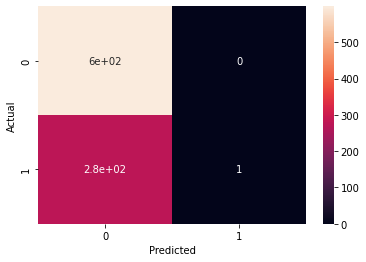

Confusion Matrix:
 [[599   0]
 [277   1]]
Accuracy Score: 0.6841505131128849
Precision Score: 0.7840252937838106
Recall Score: 0.6841505131128849
F1 Score: 0.5570155781638464


In [ ]:
from utils import sentencizer, evaluation_rb
y_test = data[metric].map({"Yes":1,"No":0})
evaluation_rb.main(y_test, final_labels)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=final_labels))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       599
           1       1.00      0.00      0.01       278

    accuracy                           0.68       877
   macro avg       0.84      0.50      0.41       877
weighted avg       0.78      0.68      0.56       877

